<a href="https://colab.research.google.com/github/Aditi336/Aditi336/blob/main/notebooks/Interacting_with_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [2]:
# this aditi run
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1ryaqhrj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-1ryaqhrj
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.6.0+cu124


/tmp/ipython-input-189856270.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [4]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 115MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7acef86972e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [7]:
clip.tokenize("Just do it")

tensor([[49406,   761,   818,   585, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [8]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "7 Up": "The Un-cola",
    # " A&W ": " A & W. All American Food",
    # " A&W Root Beer": " That frosty mug sensation",
    # "Absolut Vodka": "ABSOLUT PERFECTION",
    # "Ajinomoto  ": "Eat Well, Live Well",

}

In [10]:
import os

folder_path = '/content/images'  # Replace with your folder path
files = os.listdir(folder_path)
print(files)


['.ipynb_checkpoints', '7 Up.jpg']


7 Up.jpg
/content/images/7 Up.jpg


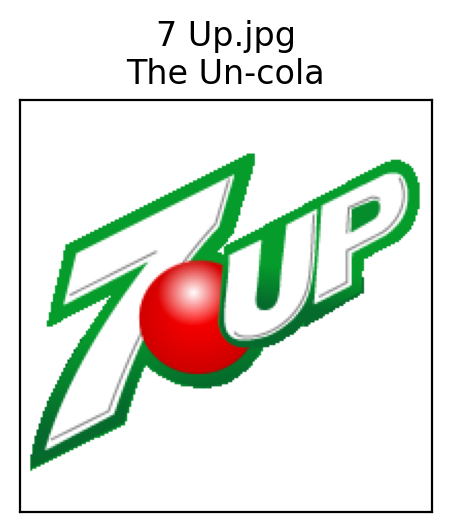

In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt

original_images = []
images = []
texts = []

plt.figure(figsize=(16, 5))

image_folder = '/content/images'  # your folder containing logo images

for filename in [f for f in os.listdir(image_folder) if f.endswith(".png") or f.endswith(".jpg")]:
    print(filename)
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image_path = os.path.join(image_folder, filename)
    print(image_path)
    image = Image.open(image_path).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))  # assuming preprocess is defined for CLIP input
    texts.append(descriptions[name])

plt.tight_layout()
plt.show()


In [12]:
print(original_images,images,texts)

[<PIL.Image.Image image mode=RGB size=200x200 at 0x7ACF011C6550>] [tensor([[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         ...,
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],

        [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         ...,
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],

        [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
         [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [13]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load your logo image (7up logo)
image = Image.open("/content/images/7 Up.jpg").convert("RGB")

# Your slogan or description text
text = "The Un-cola"

# Prepare inputs
inputs = processor(text=[text], images=image, return_tensors="pt", padding=True)
inputs = {k: v.to(device) for k,v in inputs.items()}

# Get text embeddings (normalized)
with torch.no_grad():
    text_embeds = model.get_text_features(**{k: v for k, v in inputs.items() if k.startswith("input_ids") or k.startswith("attention_mask")})
    text_embeds /= text_embeds.norm(p=2, dim=-1, keepdim=True)

# Get image embeddings (normalized)
with torch.no_grad():
    image_embeds = model.get_image_features(pixel_values=inputs["pixel_values"])
    image_embeds /= image_embeds.norm(p=2, dim=-1, keepdim=True)

print("Text embedding vector shape:", text_embeds.shape)   # e.g. (1, 512)
print("Image embedding vector shape:", image_embeds.shape) # e.g. (1, 512)

# You now have separate embeddings you can use for similarity, downstream tasks, or visualization


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Text embedding vector shape: torch.Size([1, 512])
Image embedding vector shape: torch.Size([1, 512])


In [14]:
image_input = torch.tensor(np.stack(images
)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [16]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

AttributeError: 'CLIPModel' object has no attribute 'encode_image'

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

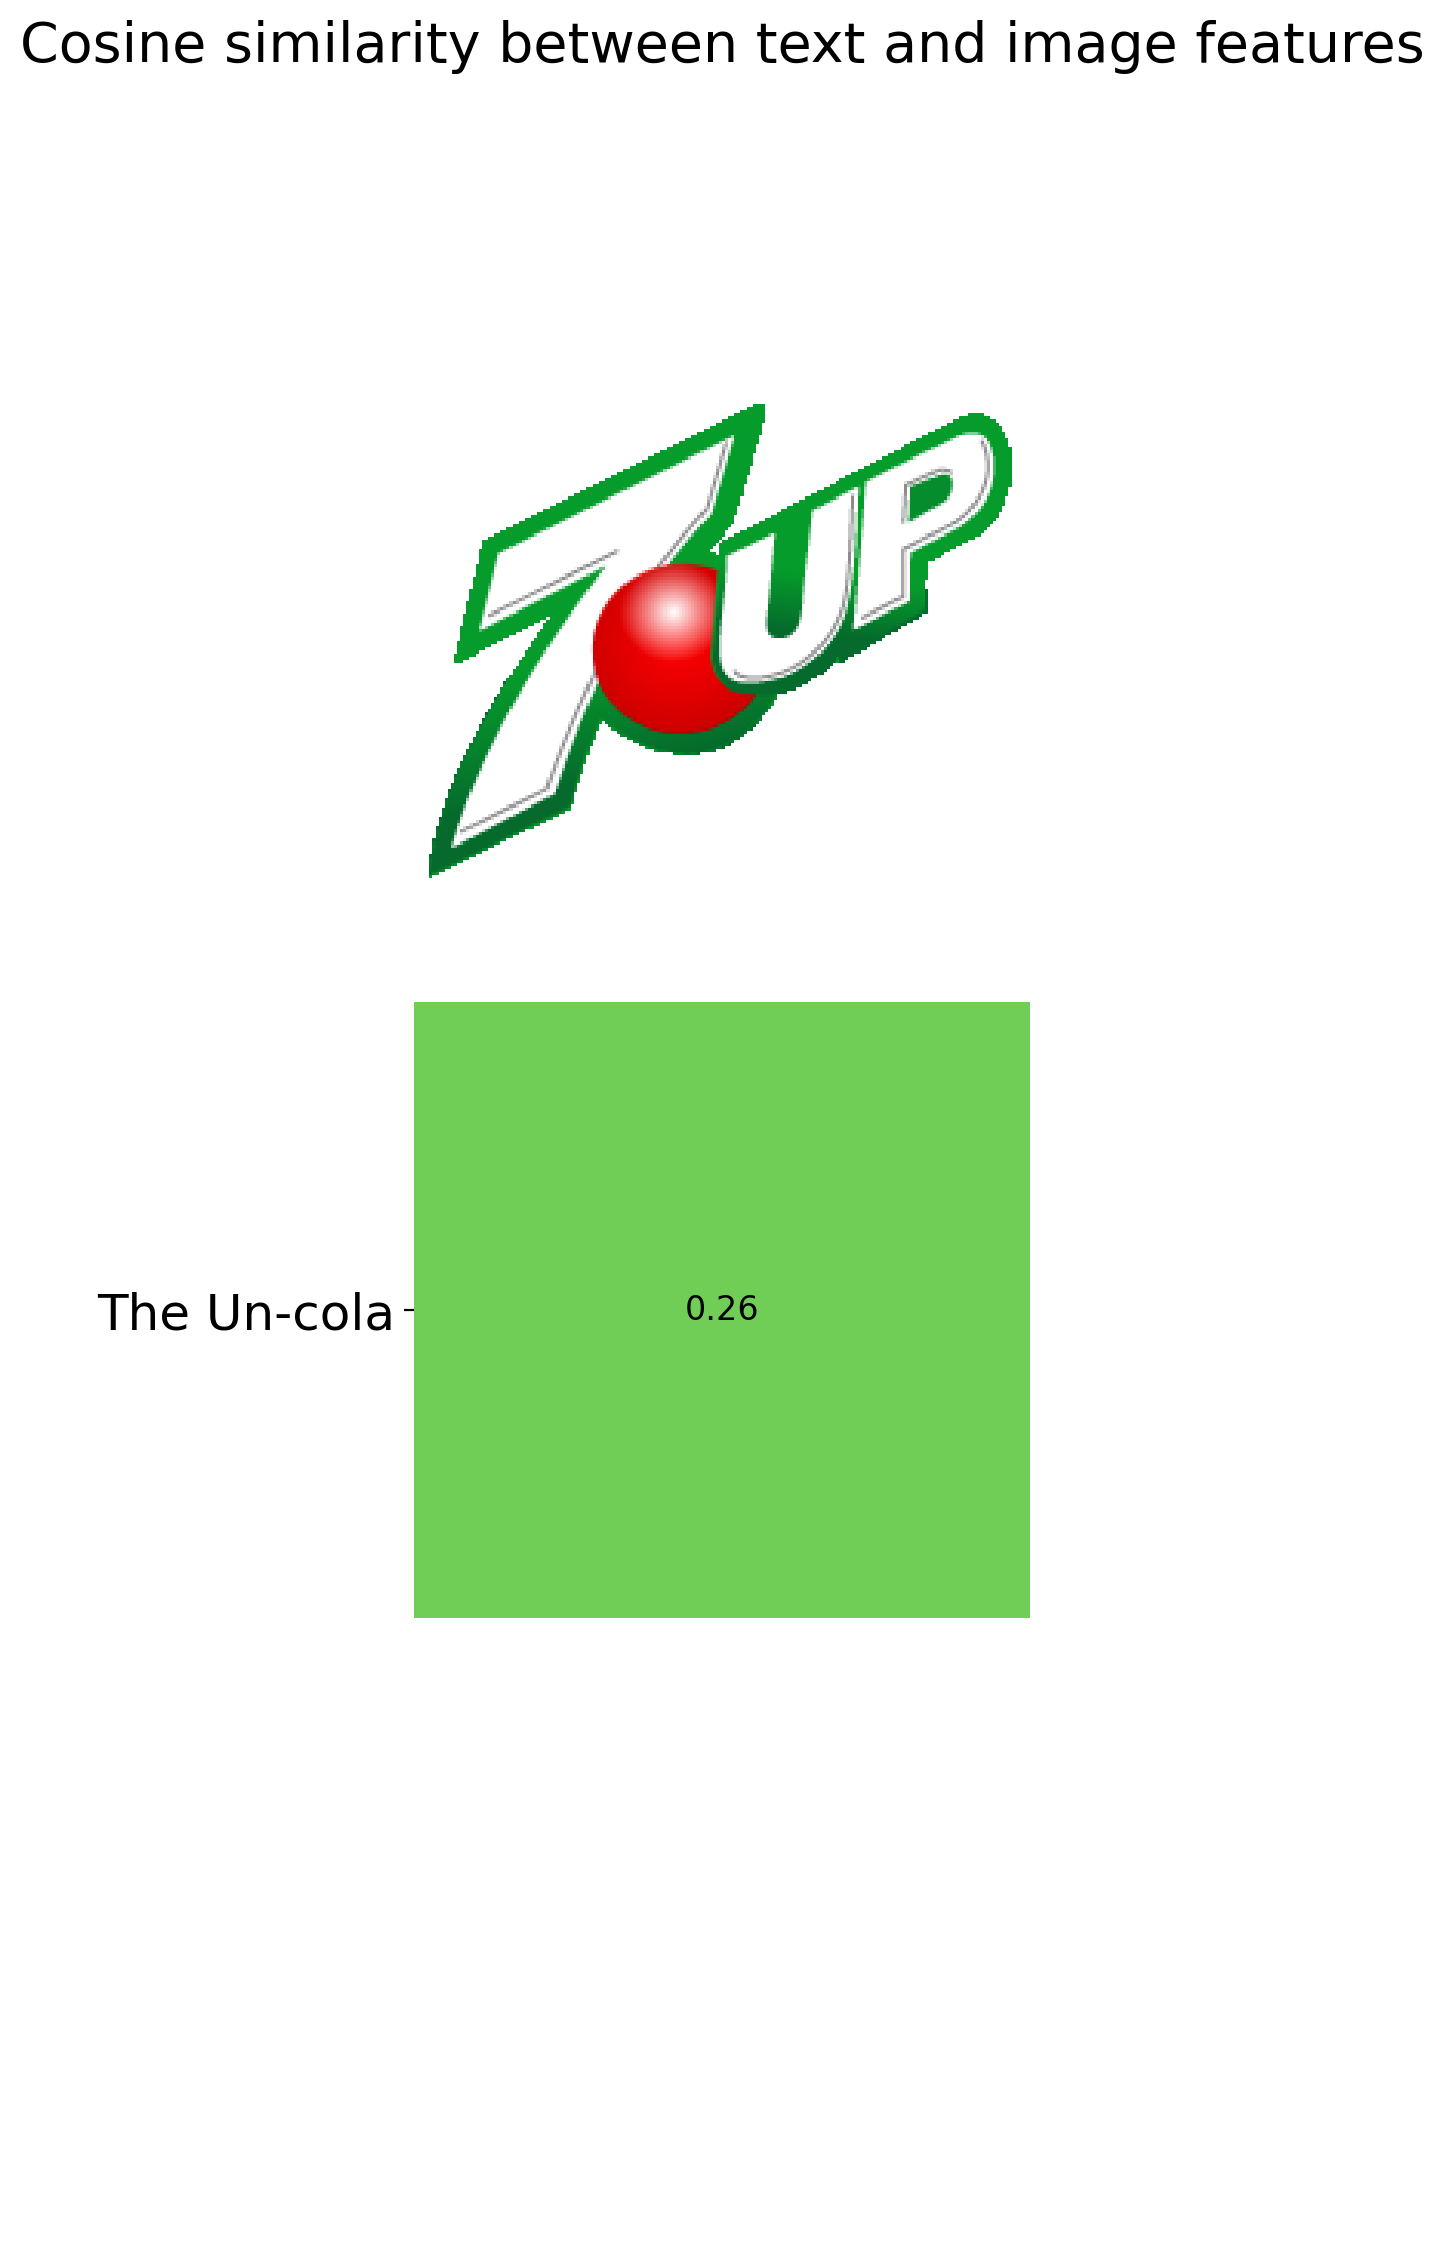

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169M/169M [00:13<00:00, 12.3MB/s]


In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

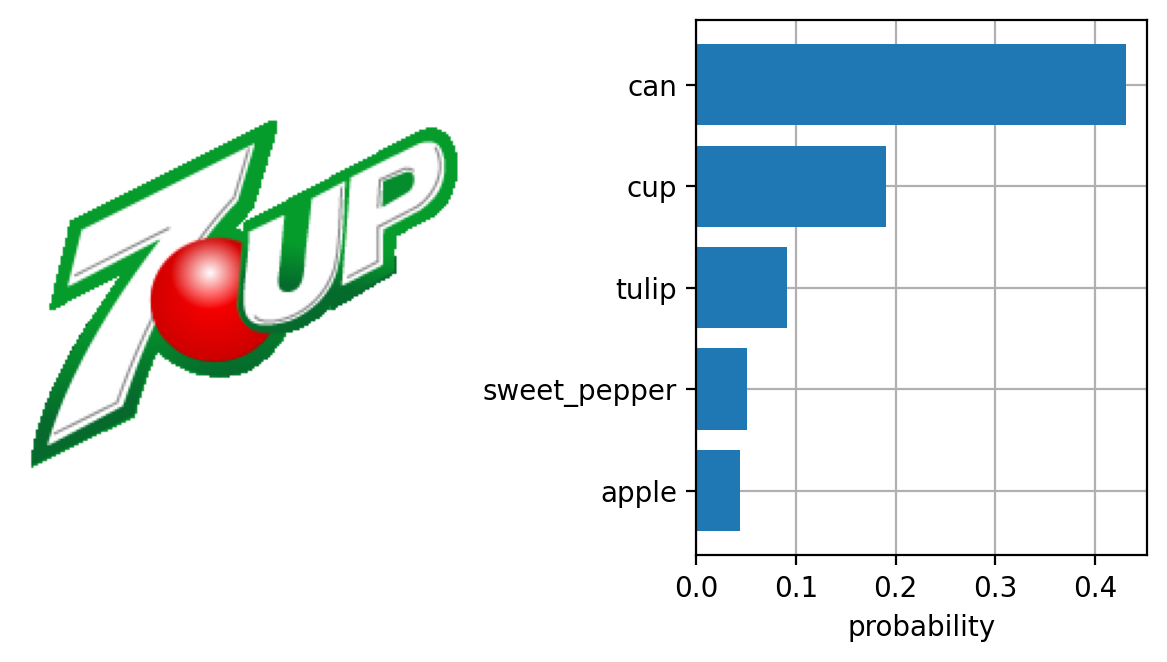

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()